# ACP Project - Predicting Critical Events 

## Setup

In [1]:
import warnings, pickle
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import shap

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import f2_score, METRICS, evaluate, evaluate_from_pred, with_sampling_strategies, spotCheckCV, spotCheckDatasets, F2TabNet
from utils.isolation_forest_wrapper import IsolationForestWrapper
%aimport utils.evaluation

In [44]:
class Notebook:
    # Remember to create these directories!
    IMAGE_DIR = 'images/critical_event_48'
    MODEL_DIR = 'models/critical_event_48' 
    SAVE_MODELS = True
    OUTCOME = "CriticalEvent"
    MODELS = {}
    EXPLAINERS = {}
    EVAL_RESULTS = {}
    TUNED_RESULTS = {}
    RUN_HYPERPARAMETERS = True
    RANDOM_SEARCH_NJOBS = 4


## Test Setup

### Dataset

Different variations on this initial, pre-processed version will be tested throughout.

In [6]:
from dataset import SCIData, SCICols
%aimport dataset

# SCIData.load('data/sci.h5').clean_all().filter_vague_diagnoses().derive_readmission().omit_vbg()
sci = SCIData.load('data/sci_processed.h5').fix_readmissionband().derive_critical_event(within=2)

In [7]:
from sklearn.model_selection import train_test_split

scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
)

sci_train, sci_test = train_test_split(
    scii, test_size=0.33, random_state=42, stratify=scii[Notebook.OUTCOME]
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

# Drop HSMR_15 as there is only 1 in the entire dataset, making a split impossible
(X_train, y_train), (X_test, y_test) = (
    sci_train.encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
    sci_test.encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
)

def drop_exclusive_cols(X1, X2):
    exclusive_cols = set(X1.columns) ^ set(X2.columns)
    X1.drop(exclusive_cols, axis=1, errors='ignore', inplace=True)
    X2.drop(exclusive_cols, axis=1, errors='ignore', inplace=True)

drop_exclusive_cols(X_train, X_test)

In [8]:
scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
)

datasets = {
    "Mandated vitals, One-hot diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses (main only)": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .drop(SCICols.diagnoses[1:], axis=1)
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses (with missing)": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .drop(SCICols.diagnoses[1:], axis=1)
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
    "Imputed vitals": (
        scii.impute_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Missing NEWS, imputed blood": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .mandate_diagnoses()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
    "Missing vitals": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .mandate_diagnoses()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
}


### Thresholding/Tuning

In [5]:
from sklearn.metrics import precision_recall_curve

def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(
        y_train, y_pred_proba
    )
    closest = thresholds[np.abs(recall-target).argmin()]
    
    return closest

## Baseline (NEWS)

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.973297,0.229391,0.249027,0.808959,0.238806,0.244836


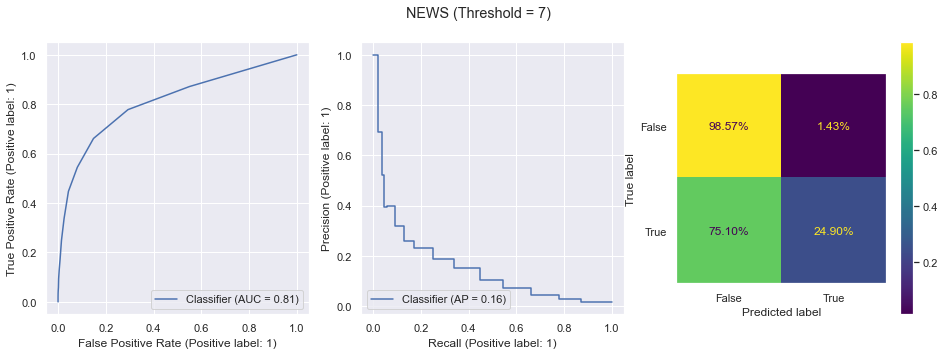

In [426]:
Notebook.EVAL_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test,
    y_pred=(sci.loc[sci_test.index].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[sci_test.index].c_NEWS_score),
    plot_title="NEWS (Threshold = 7)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news.png",
)



## Logistic Regression (NEWS only)

In [9]:
from sklearn.linear_model import LogisticRegression

datasets_lr = {
    "Raw NEWS": sci.mandate(SCICols.news_data_raw).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float
    ),
    "Scored NEWS": sci.mandate(SCICols.news_data_scored).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_scored, dtype=float
    ),
}

models = {
    "LR": LogisticRegression(max_iter=1000, random_state=42),
    "LR Balanced": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ),
}

spotCheckDatasets(models, datasets_lr)


fit_time  score_time  test_Accuracy  test_Precision  \
dataset     model                                                              
Raw NEWS    LR           1.131047    0.049669       0.984029        0.585566   
            LR Balanced  0.721194    0.062488       0.862873        0.078060   
Scored NEWS LR           0.161418    0.062489       0.983853        0.543242   
            LR Balanced  0.171841    0.057281       0.858794        0.076380   

                         test_Recall  test_AUC  test_F1 Score  test_F2 Score  
dataset     model                                                             
Raw NEWS    LR              0.057346  0.817302       0.102924       0.069666  
            LR Balanced     0.663341  0.816260       0.139240       0.263397  
Scored NEWS LR              0.051167  0.813106       0.092838       0.062354  
            LR Balanced     0.673125  0.814827       0.136870       0.261209

In [10]:
spotCheckCV(
    {
        "LR": LogisticRegression(max_iter=1000, random_state=42),
        **with_sampling_strategies(
            LogisticRegression(max_iter=1000, random_state=42), "LR"
        ),
    },
    *datasets_lr["Raw NEWS"]
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
LR,1.257982,0.059837,0.984029,0.585566,0.057346,0.817302,0.102924,0.069666
LR_OverUnder,0.330684,0.057293,0.899712,0.093995,0.578048,0.817124,0.160939,0.282092
LR_SMOTE,3.003653,0.052067,0.871016,0.082129,0.654858,0.817544,0.145424,0.271166
LR_SMOTE-Tomek,6.840883,0.072901,0.874543,0.082585,0.648382,0.816524,0.146163,0.272081
LR_Undersampling,0.247446,0.052073,0.975572,0.251003,0.219444,0.816971,0.228131,0.221428


### Evaluation with large subset

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.861302,0.074898,0.651403,0.806286,0.134349,0.256515


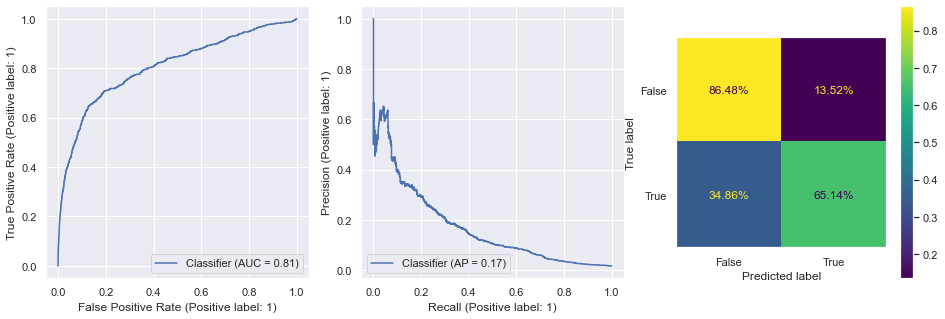

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(
    *sci.mandate(SCICols.news_data_raw).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float
    ),
    test_size=0.33,
    random_state=42
)

evaluate(
    LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
        X_train_news, y_train_news
    ),
    X_test_news,
    y_test_news,
)


#### Thresholding

The baseline model's pre-defined risk ratio (NEWS score $\geq 7$) yields its own precision and recall "ratio". I.e., it balances false-positives and negatives in a certain way. We can emulate this tradeoff by adjusting the class threshold in the regression model. 

In [12]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score


def get_news_target_ratio(X, y):
    y_pred = X.c_NEWS_score >= 7
    p = precision_score(y, y_pred)
    r = recall_score(y, y_pred)
    print(f"NEWS Precision={p:.5f}, Recall={r:.5f}")
    return p / r


# Get the "target" ratio of precision/recall that the NEWS threshold produces
target_ratio = get_news_target_ratio(
    *sci.mandate(SCICols.news_data_raw).xy(outcome=Notebook.OUTCOME)
)

# Train the LR model
model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000).fit(
    X_train_news, y_train_news
)

# Get candidate thresholds from the model, and find the one that gives the ratio closest to the target
precision, recall, thresholds = precision_recall_curve(
    y_train_news, model.predict_proba(X_train_news)[:, 1]
)
closest = thresholds[
    np.abs(
        np.divide(precision, recall, out=np.ones_like(recall), where=recall != 0)
        - target_ratio
    ).argmin()
]



NEWS Precision=0.22975, Recall=0.26733


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.973642,0.235217,0.264402,0.806286,0.248957,0.257999


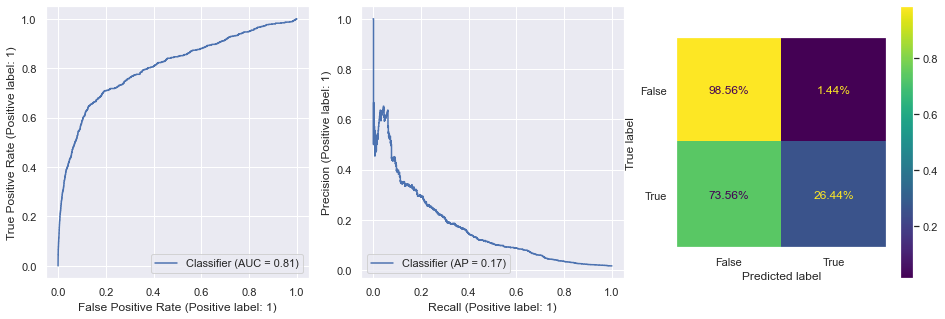

In [13]:
# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_news)
y_pred = np.where(y_pred_proba[:, 1] > closest, 1, 0)

# Produce scores
evaluate_from_pred(y_test_news, y_pred, y_pred_proba[:, 1])


### Evaluation with test set

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.846718,0.070811,0.669261,0.819662,0.128071,0.248771


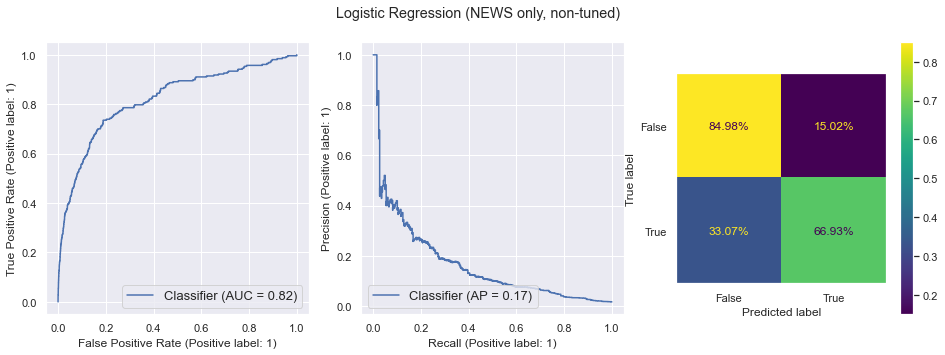

In [406]:
(X_train_news, y_train_news), (X_test_news, y_test_news) = \
    sci_train.xy(outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True), \
    sci_test.xy(outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True),

drop_exclusive_cols(X_train_news, X_test_news)

model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
        X_train_news, y_train_news
    )
Notebook.MODELS['Logistic Regression (NEWS only)'] = model

Notebook.EVAL_RESULTS['Logistic Regression (NEWS only)'] = evaluate(
    model,
    X_test_news,
    y_test_news,
    plot_title = 'Logistic Regression (NEWS only, non-tuned)',
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_news.png",
)

#### Thresholding

We adjust the classification threshold to further minimise false-negatives. Here we set it such that training recall/sensitivity is 0.85.

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.469533,0.027684,0.894942,0.819662,0.053707,0.123179


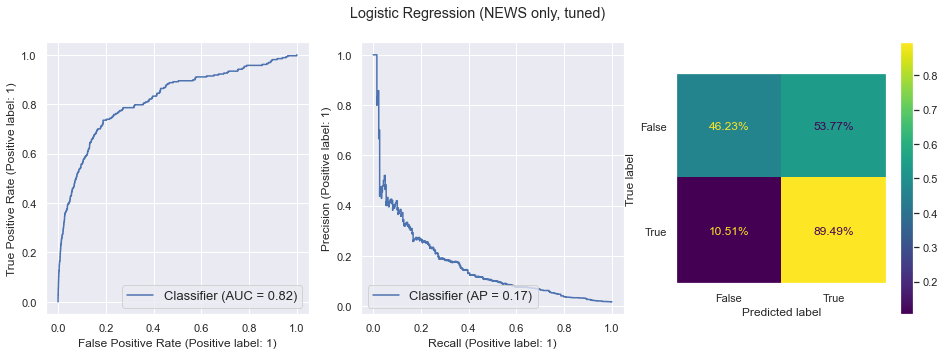

In [408]:
model = Notebook.MODELS['Logistic Regression (NEWS only)']

threshold = get_threshold(
    y_train_news, 
    model.predict_proba(X_train_news)[:, 1], 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_news)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS['Logistic Regression (NEWS only)'] = evaluate_from_pred(
    y_test_news,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_news.png",
)



## Logistic Regression

### Dataset Variants

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Logistic Regression (balanced)": LogisticRegression(
        max_iter=1000, class_weight="balanced"
    ),
    "Logistic Regression (saga)": Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            (
                "clf",
                LogisticRegression(
                    max_iter=1000,
                    class_weight="balanced",
                    solver="saga",
                    penalty="elasticnet",
                    l1_ratio=0.5,
                ),
            ),
        ]
    ),
}

spotCheckDatasets(models, datasets_lr)


fit_time  score_time  \
dataset     model                                                   
Raw NEWS    Logistic Regression              1.173881    0.057278   
            Logistic Regression (balanced)   0.906183    0.070362   
            Logistic Regression (saga)      26.020064    0.058421   
Scored NEWS Logistic Regression              0.171829    0.057277   
            Logistic Regression (balanced)   0.171830    0.062492   
            Logistic Regression (saga)      38.211232    0.057281   

                                            test_Accuracy  test_Precision  \
dataset     model                                                           
Raw NEWS    Logistic Regression                  0.984029        0.585566   
            Logistic Regression (balanced)       0.862873        0.078060   
            Logistic Regression (saga)           0.854964        0.075337   
Scored NEWS Logistic Regression                  0.983853        0.543242   
            Logistic Regression (balanced)       0.858794        0.076380   
            Logistic Regression (saga)           0.853071        0.065606   

                                            test_Recall  test_AUC  \
dataset     model                                                   
Raw NEWS    Logistic Regression                0.057346  0.817302   
            Logistic Regression (balanced)     0.663341  0.816260   
            Logistic Regression (saga)         0.677305  0.819726   
Scored NEWS Logistic Regression                0.051167  0.813106   
            Logistic Regression (balanced)     0.673125  0.814827   
            Logistic Regression (saga)         0.609538  0.765113   

                                            test_F1 Score  test_F2 Score  
dataset     model                                                         
Raw NEWS    Logistic Regression                  0.102924       0.069666  
            Logistic Regression (balanced)       0.139240       0.263397  
            Logistic Regression (saga)           0.135182       0.258777  
Scored NEWS Logistic Regression                  0.092838       0.062354  
            Logistic Regression (balanced)       0.136870       0.261209  
            Logistic Regression (saga)           0.118444       0.229227

### Resampling

In [15]:
dataset = datasets["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = SCIData(dataset[0]).describe_categories()[0]
spotCheckCV(
    {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Logistic Regression (balanced)": LogisticRegression(
            max_iter=1000, class_weight="balanced"
        ),
        **with_sampling_strategies(
            LogisticRegression(max_iter=1000),
            "Logistic Regression",
            categorical_cols_idx,
        ),
        **with_sampling_strategies(
            LogisticRegression(max_iter=1000, class_weight="balanced"),
            "Logistic Regression (balanced)",
            categorical_cols_idx,
        ),
    },
    *dataset
)




1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\imblearn\pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\imblearn\pipeline.py", line 236, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\joblib\memory.py", line 349, 

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Logistic Regression,6.708921,0.031243,0.982718,0.455950,0.103268,0.888460,0.168222,0.122125
Logistic Regression (balanced),6.622442,0.031238,0.850962,0.085484,0.802614,0.890262,0.154385,0.299133
Logistic Regression (balanced)_OverUnder,3.954378,0.026034,0.859183,0.088073,0.781699,0.888495,0.158213,0.303123
Logistic Regression (balanced)_SMOTE,17.565986,0.031242,0.860907,0.088996,0.772549,0.883493,0.159282,0.303180
Logistic Regression (balanced)_SMOTE-Tomek,156.978640,0.041658,0.858608,0.087701,0.775163,0.885325,0.157295,0.300633
Logistic Regression (balanced)_Undersampling,1.297574,0.026035,0.847603,0.084462,0.809150,0.891446,0.152830,0.297311
Logistic Regression_OverUnder,3.923307,0.026033,0.920486,0.134343,0.673203,0.885496,0.223565,0.372300
Logistic Regression_SMOTE,17.254935,0.036447,0.861106,0.088812,0.764706,0.883448,0.158730,0.301384
Logistic Regression_SMOTE-Tomek,72.914366,0.026047,0.854046,0.087588,0.803922,0.897415,0.157795,0.304228


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.852412,0.083403,0.77821,0.890191,0.150659,0.291886


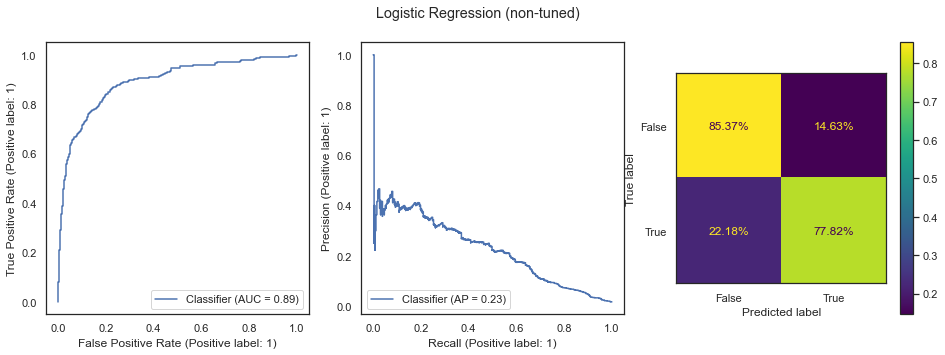

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

model = LogisticRegression(max_iter=1000, class_weight="balanced").fit(X_train, y_train)

Notebook.EVAL_RESULTS['Logistic Regression'] = evaluate(
    model,
    X_test,
    y_test,
    plot_title="Logistic Regression (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_regression.png",
)

Notebook.MODELS["Logistic Regression"] = model


#### Thresholding

We adjust the classification threshold to further minimise false-negatives. Here we set it such that training recall/sensitivity is 0.85.

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.835788,0.076373,0.789883,0.890191,0.13928,0.275366


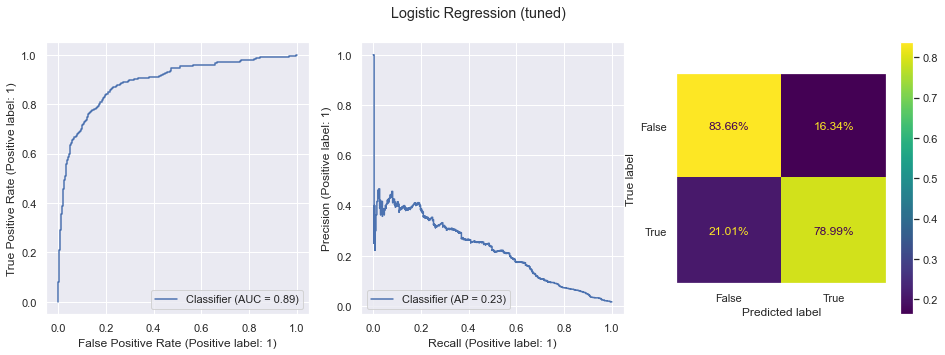

In [188]:
model = Notebook.MODELS["Logistic Regression"]

threshold = get_threshold(
    y_train, 
    model.predict_proba(X_train)[:, 1], 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS['Logistic Regression'] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_regression.png",
)



### Explanations

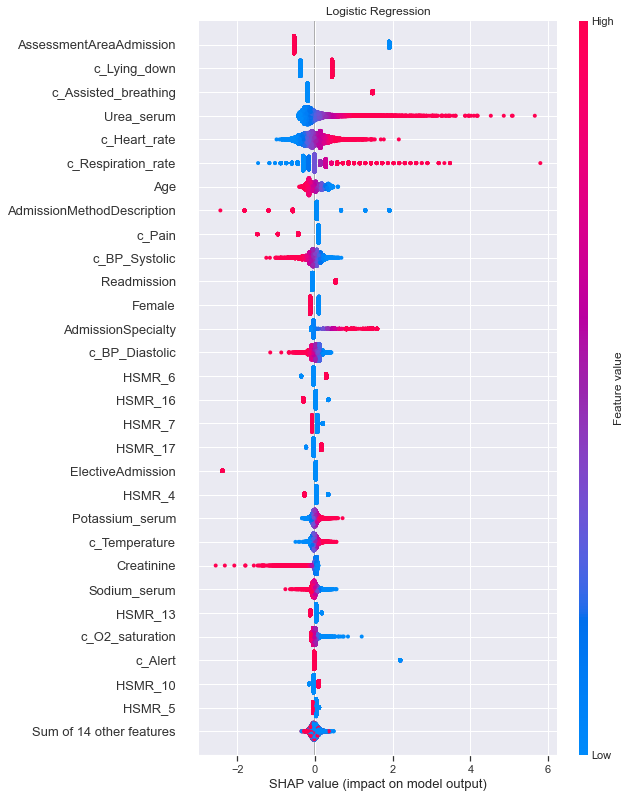

In [18]:
import shap

explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_test)
Notebook.EXPLAINERS["Logistic Regression"] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values, max_display=30, show=False)
plt.title("Logistic Regression")
plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight")


In [19]:
sns.set_style('white')
positive_class_idx = np.where(model.predict(X_test))[0][-1]
fig = shap.plots.force(shap_values[positive_class_idx], matplotlib=True)

shap.save_html(f"{Notebook.IMAGE_DIR}/force_plot_logistic_regression.html", fig)
display(fig)
sns.set_style('darkgrid')

## XGBoost


### Dataset Variants

In [20]:
datasets_xgb = {
    "Mandated vitals, One-hot diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .impute_blood()
        .augment_hsmr()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Imputed vitals, One-hot diagnoses": (
        scii.impute_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Mandated NEWS, imputed blood, One-hot diagnoses": (
        scii.mandate_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Missing NEWS, imputed blood, One-hot diagnoses": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Missing blood & NEWS, One-hot diagnoses": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
}


In [21]:
from xgboost import XGBClassifier

xgb_weight_lambda = lambda X, y: dict(scale_pos_weight=y.shape[0] / y.sum())

xgb_set_params = {
    "XGB Balanced": xgb_weight_lambda,
    "Hist XGB Balanced": xgb_weight_lambda,
}

models = {
    "Approx XGB": XGBClassifier(
        tree_method="approx", enable_categorical=True, scale_pos_weight=1
    ),
    "Approx XGB Balanced": XGBClassifier(
        tree_method="approx", enable_categorical=True,
    ),
    "Hist XGB": XGBClassifier(
        tree_method="hist", enable_categorical=True, scale_pos_weight=1
    ),
    "Hist XGB Balanced": XGBClassifier(tree_method="hist", enable_categorical=True,),
}

spotCheckDatasets(datasets=datasets_xgb, models=models, set_params=xgb_set_params)


fit_time  \
dataset                                         model                            
Imputed vitals, One-hot diagnoses               Approx XGB           32.558444   
                                                Approx XGB Balanced  31.075734   
                                                Hist XGB              4.901939   
                                                Hist XGB Balanced     5.170520   
Mandated NEWS, imputed blood, One-hot diagnoses Approx XGB           18.262594   
                                                Approx XGB Balanced  18.029536   
                                                Hist XGB              2.768472   
                                                Hist XGB Balanced     2.820265   
Mandated vitals, Categorical diagnoses          Approx XGB            9.140647   
                                                Approx XGB Balanced   8.316207   
                                                Hist XGB              1.308152   
                                                Hist XGB Balanced     1.335938   
Mandated vitals, One-hot diagnoses              Approx XGB            9.190975   
                                                Approx XGB Balanced  10.285902   
                                                Hist XGB              1.782147   
                                                Hist XGB Balanced     1.765209   
Missing NEWS, imputed blood, One-hot diagnoses  Approx XGB           31.017361   
                                                Approx XGB Balanced  31.055911   
                                                Hist XGB              6.413992   
                                                Hist XGB Balanced     5.036691   
Missing blood & NEWS, One-hot diagnoses         Approx XGB           30.914103   
                                                Approx XGB Balanced  30.888980   
                                                Hist XGB              6.637064   
                                                Hist XGB Balanced     5.145530   

                                                                     score_time  \
dataset                                         model                             
Imputed vitals, One-hot diagnoses               Approx XGB             1.042004   
                                                Approx XGB Balanced    1.077821   
                                                Hist XGB               1.174750   
                                                Hist XGB Balanced      1.213378   
Mandated NEWS, imputed blood, One-hot diagnoses Approx XGB             0.525917   
                                                Approx XGB Balanced    0.616827   
                                                Hist XGB               0.621366   
                                                Hist XGB Balanced      0.624858   
Mandated vitals, Categorical diagnoses          Approx XGB             0.263234   
                                                Approx XGB Balanced    0.274619   
                                                Hist XGB               0.286256   
                                                Hist XGB Balanced      0.310014   
Mandated vitals, One-hot diagnoses              Approx XGB             0.343669   
                                                Approx XGB Balanced    0.380117   
                                                Hist XGB               0.404754   
                                                Hist XGB Balanced      0.405494   
Missing NEWS, imputed blood, One-hot diagnoses  Approx XGB             1.151495   
                                                Approx XGB Balanced    1.309490   
                                                Hist XGB               1.299314   
                                                Hist XGB Balanced      1.175023   
Missing blood & NEWS, One-hot diagnoses         Approx XGB             1.176909   
                            

### Resampling

In [22]:
X, y = datasets_xgb["Mandated NEWS, imputed blood, One-hot diagnoses"]
categorical_cols_idx = X.describe_categories()[0]
X = X.ordinal_encode_categories().fillna(-1)
scale_pos_weight = y.shape[0] / y.sum()
spotCheckCV(
    {
        "XGB": XGBClassifier(
            tree_method="hist",
            enable_categorical=True,
            scale_pos_weight=scale_pos_weight,
        ),
        **with_sampling_strategies(
            XGBClassifier(
                tree_method="hist",
                enable_categorical=True,
                scale_pos_weight=scale_pos_weight,
            ),
            "XGB",
            categorical_cols_idx,
        ),
    },
    X,
    y,
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XGB,1.981246,0.395740,0.965620,0.271882,0.555676,0.900893,0.364720,0.459194
XGB_OverUnder,4.866452,0.343667,0.924932,0.158036,0.740712,0.910945,0.260321,0.425848
XGB_SMOTE,13.190739,0.367615,0.958569,0.236139,0.592801,0.896508,0.337552,0.454978
XGB_SMOTE-Tomek,655.078291,0.379881,0.959560,0.238702,0.580623,0.897398,0.338299,0.451297
XGB_Undersampling,0.676828,0.324149,0.930332,0.168272,0.736659,0.914383,0.273778,0.439155


### Hyperparameters

In [23]:
param_grid = {
    "XGB__max_depth": np.arange(10, 25, 1),
    "XGB__learning_rate": [0.01, 0.025, 0.05, 0.085, 0.1, 0.15, 0.2, 0.25, 0.3],
    "XGB__subsample": np.arange(0.3, 1.0, 0.05),
    "XGB__colsample_bytree": np.arange(0.1, 1.0, 0.05),
    "XGB__colsample_bylevel": np.arange(0.6, 1.0, 0.05),
    "XGB__n_estimators": np.arange(50, 250, 10),
    "XGB__scale_pos_weight": np.arange(1, 60, 2),
}


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.96505,0.253119,0.552529,0.925394,0.347188,0.446822


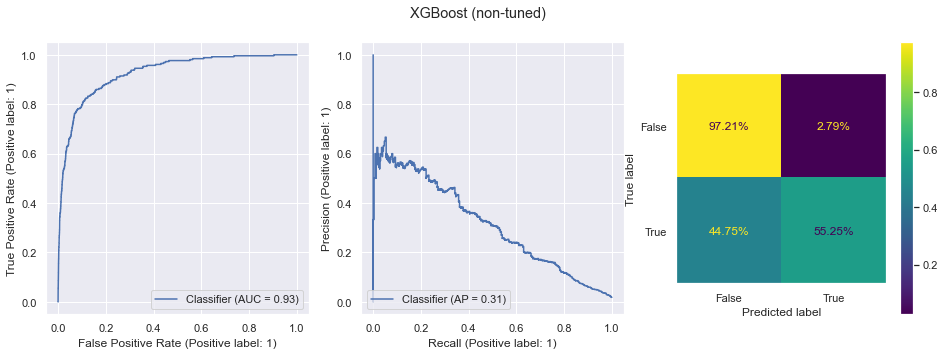

In [24]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        (
            "XGB",
            XGBClassifier(
                tree_method="approx",
                enable_categorical=True,
                subsample=0.85,
                scale_pos_weight=31,
                n_estimators=140,
                max_depth=13,
                learning_rate=0.05,
                colsample_bytree=0.7,
                colsample_bylevel=0.9,
            ),
        ),
    ]
).fit(X_train, y_train)

Notebook.EVAL_RESULTS['XGBoost'] = evaluate(
    model, X_test, y_test, "XGBoost (non-tuned)", save=f"{Notebook.IMAGE_DIR}/eval_xgboost.png"
)

Notebook.MODELS["XGBoost"] = model



#### Thresholding

We adjust the classification threshold to further minimise false-negatives. Here we set it such that training recall/sensitivity is 0.85.

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.706656,0.050628,0.92607,0.925394,0.096006,0.207715


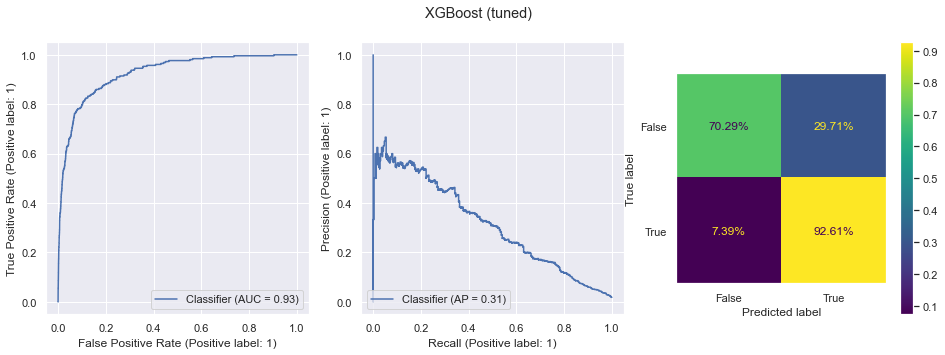

In [190]:
model = Notebook.MODELS["XGBoost"]

threshold = get_threshold(
    y_train, 
    model.predict_proba(X_train)[:, 1], 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > 1-threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS['XGBoost'] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_xgboost.png",
)



### Explanations

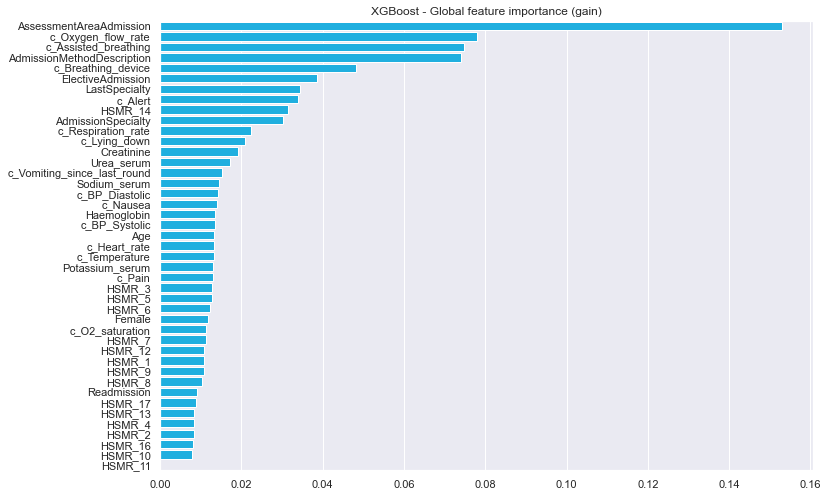

In [26]:
sorted_idx = model["XGB"].feature_importances_.argsort()[::-1]
fig = sns.barplot(
    x=model["XGB"].feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
)
fig.set_title("XGBoost - Global feature importance (gain)")
plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_xgboost.png", bbox_inches="tight")



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


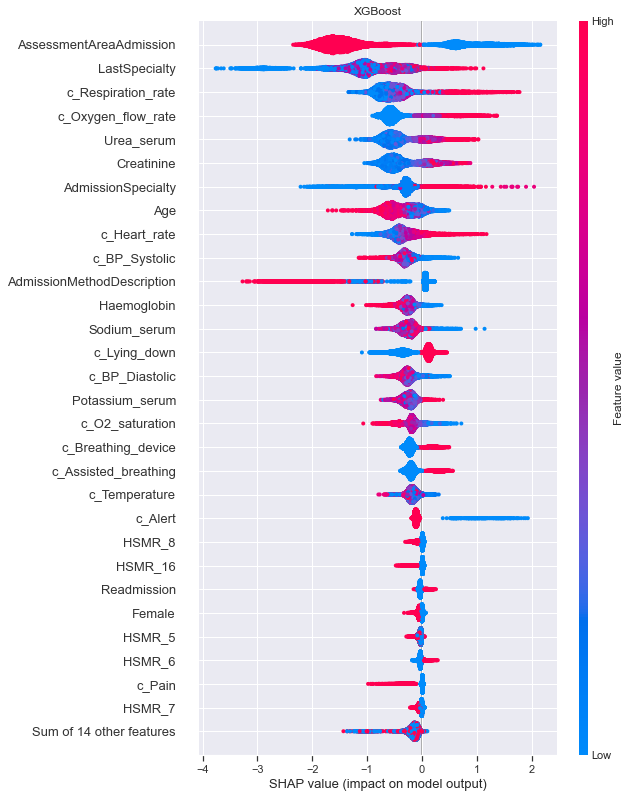

In [27]:
import shap

explainer = shap.TreeExplainer(model["XGB"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS["XGBoost"] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values, max_display=30, show=False)
plt.title("XGBoost")
plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_xgboost.png", bbox_inches="tight")


In [28]:
sns.set_style('white')
positive_class_idx = np.where(model.predict(X_test))[0][-1]
fig = shap.plots.force(shap_values[positive_class_idx], matplotlib=True)

shap.save_html(f"{Notebook.IMAGE_DIR}/force_plot_xgboost.html", fig)
display(fig)
sns.set_style('darkgrid')


## Random Forest

### Dataset Variants

In [29]:
from sklearn.ensemble import RandomForestClassifier

models = {
    "Random Forest": RandomForestClassifier(),
    "Random Forest (balanced)": RandomForestClassifier(
        class_weight="balanced_subsample"
    ),
}


In [30]:
spotCheckDatasets(datasets=datasets, models=models)


fit_time  \
dataset                                            model                                 
Imputed vitals                                     Random Forest             26.058863   
                                                   Random Forest (balanced)  23.146731   
Mandated vitals, Categorical diagnoses (main only) Random Forest              5.011895   
                                                   Random Forest (balanced)   4.511541   
Mandated vitals, Categorical diagnoses (with mi... Random Forest              5.163576   
                                                   Random Forest (balanced)   4.591235   
Mandated vitals, One-hot diagnoses                 Random Forest              4.996267   
                                                   Random Forest (balanced)   4.460577   
Missing NEWS, imputed blood                        Random Forest             25.653606   
                                                   Random Forest (balanced)  23.658306   
Missing vitals                                     Random Forest             25.855724   
                                                   Random Forest (balanced)  23.729543   

                                                                             score_time  \
dataset                                            model                                  
Imputed vitals                                     Random Forest               2.463678   
                                                   Random Forest (balanced)    2.500649   
Mandated vitals, Categorical diagnoses (main only) Random Forest               0.479054   
                                                   Random Forest (balanced)    0.387792   
Mandated vitals, Categorical diagnoses (with mi... Random Forest               0.510299   
                                                   Random Forest (balanced)    0.453019   
Mandated vitals, One-hot diagnoses                 Random Forest               0.513880   
                                                   Random Forest (balanced)    0.458227   
Missing NEWS, imputed blood                        Random Forest               2.562880   
                                                   Random Forest (balanced)    2.355857   
Missing vitals                                     Random Forest               2.585942   
                                                   Random Forest (balanced)    2.402561   

                                                                             test_Accuracy  \
dataset                                            model                                     
Imputed vitals                                     Random Forest                  0.983995   
                                                   Random Forest (balanced)       0.983778   
Mandated vitals, Categorical diagnoses (main only) Random Forest                  0.983470   
                                                   Random Forest (balanced)       0.983249   
Mandated vitals, Categorical diagnoses (with mi... Random Forest                  0.983434   
                                                   Random Forest (balanced)       0.983434   
Mandated vitals, One-hot diagnoses                 Random Forest                  0.983536   
                                                   Random Forest (balanced)       0.983359   
Missing NEWS, imputed blood                        Random Forest                  0.984205   
                                                   Random Forest (balanced)       0.983803   
Missing vitals                                     Random Forest                  0.984139   
                                                   Random Forest (balanced)       0.983797   

                                                                             test_Precision  \
dataset                                            model                                      
Imputed vitals                     

### Resampling

In [31]:
dataset = datasets["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = SCIData(dataset[0]).describe_categories()[0]
spotCheckCV(
    {
        "Random Forest": RandomForestClassifier(),
        **with_sampling_strategies(
            RandomForestClassifier(), "Random Forest", categorical_cols_idx
        ),
    },
    *dataset
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Random Forest,4.821684,0.542094,0.983227,0.588137,0.031373,0.913288,0.059309,0.038654
Random Forest_OverUnder,3.173731,0.484643,0.978276,0.382649,0.444444,0.928758,0.408590,0.428636
Random Forest_SMOTE,16.134084,0.522810,0.982939,0.488999,0.088889,0.924120,0.149179,0.106001
Random Forest_SMOTE-Tomek,154.502369,0.572277,0.983116,0.506263,0.094118,0.924138,0.157479,0.112141
Random Forest_Undersampling,0.952900,0.494679,0.978188,0.376231,0.430065,0.930907,0.398996,0.416396


### Evaluation

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.980692,0.407767,0.326848,0.909422,0.362851,0.340357


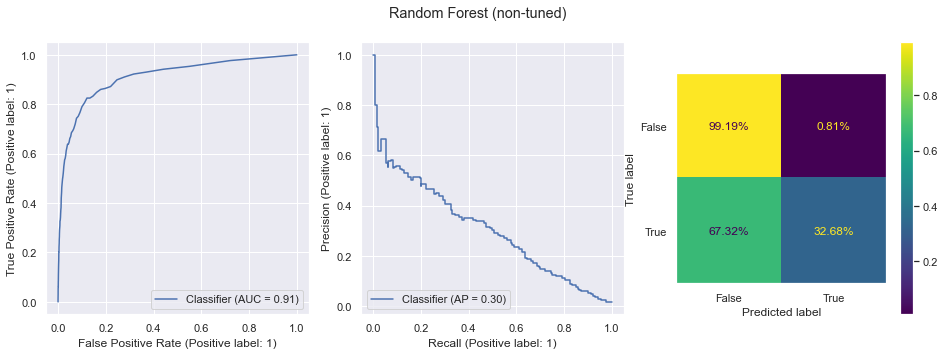

In [32]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        ("randomforest", RandomForestClassifier()),
    ]
).fit(X_train, y_train)

Notebook.MODELS["Random Forest"] = model

Notebook.EVAL_RESULTS['Random Forest'] = evaluate(
    model,
    X_test,
    y_test,
    plot_title="Random Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_random_forest.png",
)



#### Thresholding

We adjust the classification threshold to further minimise false-negatives. Here we set it such that training recall/sensitivity is 0.85.

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.963807,0.250842,0.579767,0.909422,0.350176,0.459309


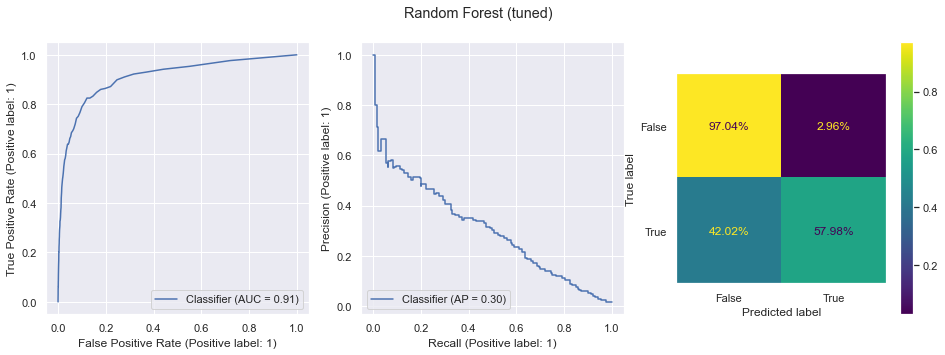

In [192]:
model = Notebook.MODELS["Random Forest"]

threshold = get_threshold(
    y_train, 
    model.predict_proba(X_train)[:, 1], 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > 1-threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS['Random Forest'] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_random_forest.png",
)



### Explanations

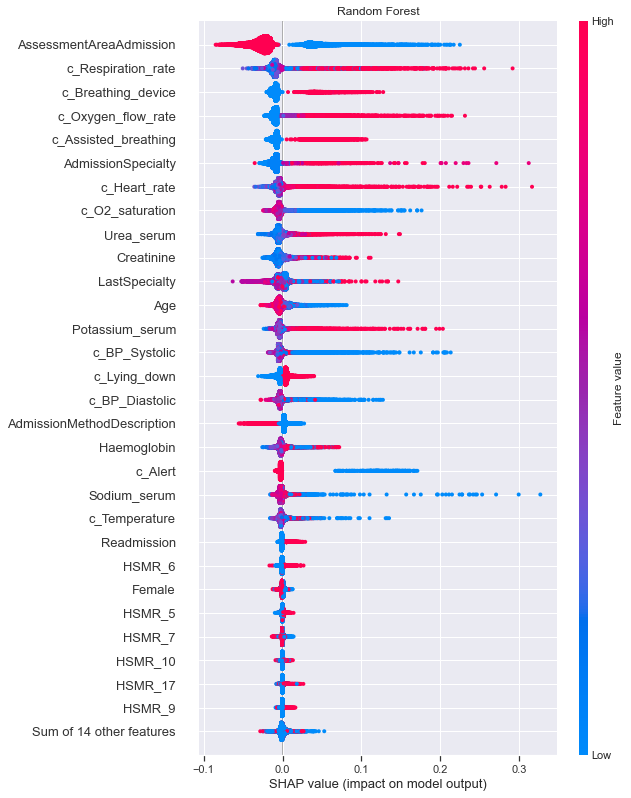

In [34]:
import shap

explainer = shap.TreeExplainer(model["randomforest"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS["Random Forest"] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values[:, :, 1], max_display=30, show=False)
plt.title("Random Forest")
plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_random_forest.png", bbox_inches="tight")


In [35]:
sns.set_style('white')
positive_class_idx = np.where(model.predict(X_test))[0][-1]
fig = shap.plots.force(shap_values[positive_class_idx, :, 1], matplotlib=True)

shap.save_html(f"{Notebook.IMAGE_DIR}/force_plot_random_forest.html", fig)
display(fig)
sns.set_style('darkgrid')


X has feature names, but RandomForestClassifier was fitted without feature names


## Isolation Forest

Unlike other models tested, this is a one-class model that detects outliers instead of predicting outcomes. We test the hypothesis that "abnormal" values associated with the tracked outcome will be outliers compared to the normal ranges.

### Dataset Variants

In [36]:
models = {
    "Isolation Forest": IsolationForestWrapper(),
    "Isolation Forest (contamination)": IsolationForestWrapper(),
}
isolation_forest_set_params = {
    "Isolation Forest (contamination)": lambda X, y: dict(
        contamination=(y.sum()) / y.shape[0]
    )
}


In [37]:
spotCheckDatasets(
    datasets=datasets, models=models, set_params=isolation_forest_set_params
)


fit_time  \
dataset                                            model                                         
Imputed vitals                                     Isolation Forest                   6.223660   
                                                   Isolation Forest (contamination)  16.736036   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                   1.277458   
                                                   Isolation Forest (contamination)   3.389471   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                   1.323495   
                                                   Isolation Forest (contamination)   3.474983   
Mandated vitals, One-hot diagnoses                 Isolation Forest                   1.893287   
                                                   Isolation Forest (contamination)   4.433313   
Missing NEWS, imputed blood                        Isolation Forest                   6.231529   
                                                   Isolation Forest (contamination)  16.675608   
Missing vitals                                     Isolation Forest                   6.260327   
                                                   Isolation Forest (contamination)  16.611972   

                                                                                     score_time  \
dataset                                            model                                          
Imputed vitals                                     Isolation Forest                   10.266713   
                                                   Isolation Forest (contamination)   10.119241   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                    2.064535   
                                                   Isolation Forest (contamination)    2.090573   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                    2.137208   
                                                   Isolation Forest (contamination)    2.153102   
Mandated vitals, One-hot diagnoses                 Isolation Forest                    2.727442   
                                                   Isolation Forest (contamination)    2.413577   
Missing NEWS, imputed blood                        Isolation Forest                   10.369309   
                                                   Isolation Forest (contamination)   10.176381   
Missing vitals                                     Isolation Forest                   10.090824   
                                                   Isolation Forest (contamination)   10.090548   

                                                                                     test_Accuracy  \
dataset                                            model                                             
Imputed vitals                                     Isolation Forest                       0.902527   
                                                   Isolation Forest (contamination)       0.967719   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                       0.914100   
                                                   Isolation Forest (contamination)       0.970033   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                       0.919503   
                                                   Isolation Forest (contamination)       0.971490   
Mandated vitals, One-hot diagnoses                 Isolation Forest                       0.887692   
                                                   Isolation Forest (contamination)       0.969680   
Missing NEWS, imputed blood                        Isolation Forest                       0.823102   
                                                   Isolation Forest (contamination)       0.965478   
Missing vitals                                     Isolation Forest                       0.831000   


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.922704,0.092593,0.40856,0.838115,0.150971,0.242831


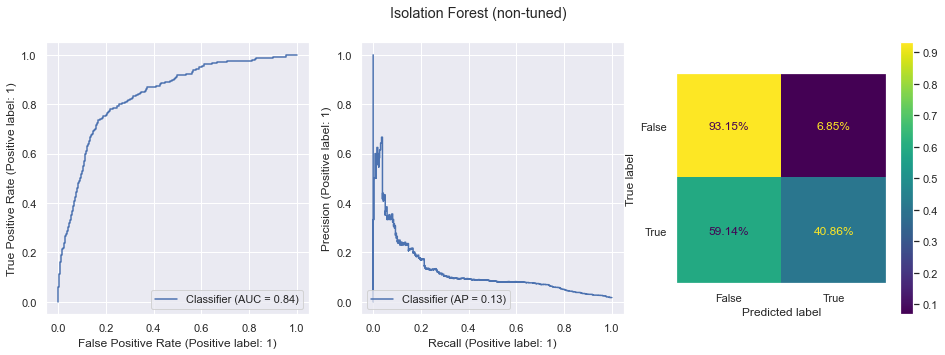

In [38]:
from sklearn.ensemble import IsolationForest

# Mandated vitals, Categorical diagnoses (main only)
(X_train_if, y_train_if), (X_test_if, y_test_if) = (
    sci_train.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
    sci_test.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
)
drop_exclusive_cols(X_train_if, X_test_if)

# Train without positive labelled instances
model = IsolationForestWrapper().fit(X_train_if[~y_train_if].to_numpy())

Notebook.MODELS["Isolation Forest"] = model

Notebook.EVAL_RESULTS['Isolation Forest'] = evaluate(
    model,
    X_test_if.to_numpy(),
    y_test_if,
    plot_title="Isolation Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_isolation_forest.png",
)


#### Thresholding

We adjust the classification threshold to further minimise false-negatives. Here we set it such that training recall/sensitivity is 0.85.

X has feature names, but IsolationForestWrapper was fitted without feature names
X has feature names, but IsolationForestWrapper was fitted without feature names


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.701682,0.044675,0.821012,0.838115,0.084739,0.183446


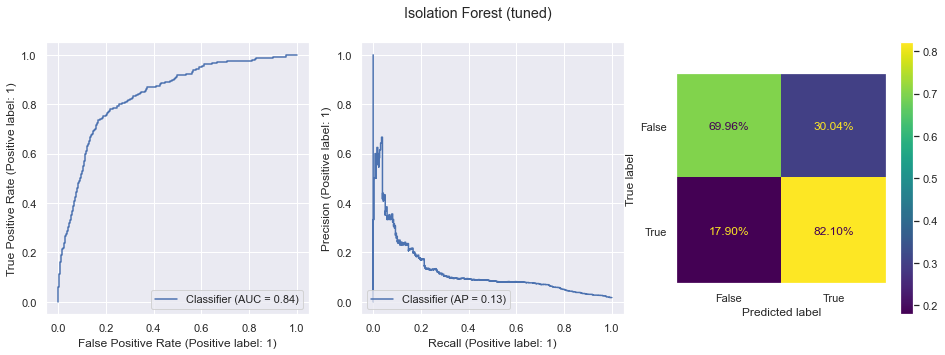

In [194]:
model = Notebook.MODELS["Isolation Forest"]

y_pred_proba_train = model.decision_function(X_train_if)
y_pred_proba_train -= y_pred_proba_train.min()

threshold = get_threshold(
    y_train_if, 
    y_pred_proba_train, 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.decision_function(X_test_if)
y_pred = np.where(y_pred_proba-y_pred_proba.min() > threshold, 1, 0)

Notebook.TUNED_RESULTS['Isolation Forest'] = evaluate_from_pred(
    y_test_if,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_isolation_forest.png",
)


### Explanations

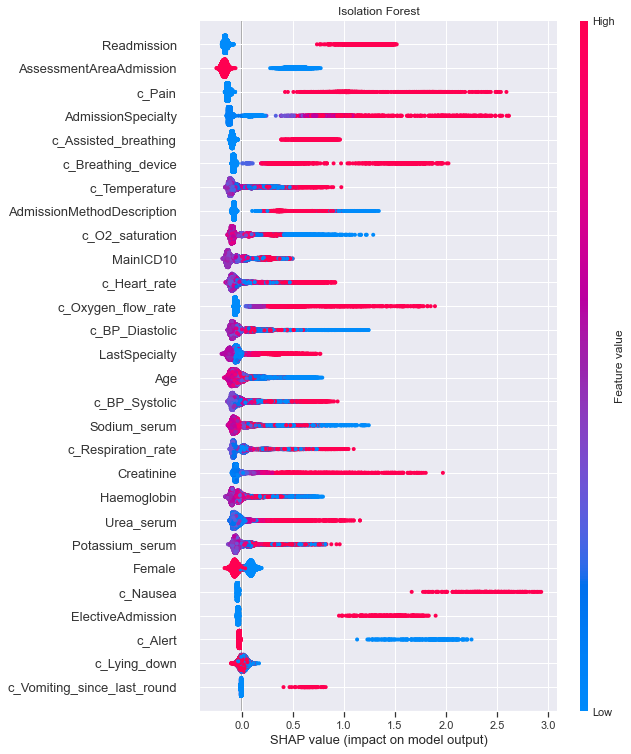

In [40]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_if)
shap_values.values = -shap_values.values  # Fix for isolation forest's unique labelling
Notebook.EXPLAINERS["Isolation Forest"] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values, max_display=30, show=False)
plt.title("Isolation Forest")
plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_isolation_forest.png", bbox_inches="tight")


In [41]:
sns.set_style('white')
positive_class_idx = np.where(model.predict(X_test_if.to_numpy()))[0][-1]
fig = shap.plots.force(shap_values[positive_class_idx], matplotlib=True)

shap.save_html(f"{Notebook.IMAGE_DIR}/force_plot_random_forest.html", fig)
display(fig)
sns.set_style('darkgrid')


## LightGBM

### Dataset Variants

In [42]:
from lightgbm import LGBMClassifier

lightgbm_set_params = {
    "LightGBM Weighted": lambda X, y: dict(scale_pos_weight=y.shape[0] / y.sum())
}

spotCheckDatasets(
    datasets=datasets_xgb,
    models={
        "LightGBM": LGBMClassifier(metric=["l2", "auc"]),
        "LightGBM Balanced": LGBMClassifier(metric=["l2", "auc"], is_unbalance=True),
        "LightGBM Weighted": LGBMClassifier(metric=["l2", "auc"]),
    },
    set_params=lightgbm_set_params,
)



fit_time  \
dataset                                         model                         
Imputed vitals, One-hot diagnoses               LightGBM           2.326261   
                                                LightGBM Balanced  2.463033   
                                                LightGBM Weighted  2.473490   
Mandated NEWS, imputed blood, One-hot diagnoses LightGBM           1.349913   
                                                LightGBM Balanced  1.452178   
                                                LightGBM Weighted  1.460555   
Mandated vitals, Categorical diagnoses          LightGBM           0.749912   
                                                LightGBM Balanced  0.755029   
                                                LightGBM Weighted  0.784240   
Mandated vitals, One-hot diagnoses              LightGBM           0.706637   
                                                LightGBM Balanced  0.666511   
                                                LightGBM Weighted  0.744618   
Missing NEWS, imputed blood, One-hot diagnoses  LightGBM           2.485111   
                                                LightGBM Balanced  2.666764   
                                                LightGBM Weighted  2.703119   
Missing blood & NEWS, One-hot diagnoses         LightGBM           2.468711   
                                                LightGBM Balanced  2.696227   
                                                LightGBM Weighted  2.653199   

                                                                   score_time  \
dataset                                         model                           
Imputed vitals, One-hot diagnoses               LightGBM             1.416339   
                                                LightGBM Balanced    1.729165   
                                                LightGBM Weighted    1.794032   
Mandated NEWS, imputed blood, One-hot diagnoses LightGBM             0.775860   
                                                LightGBM Balanced    1.049630   
                                                LightGBM Weighted    1.012755   
Mandated vitals, Categorical diagnoses          LightGBM             0.407362   
                                                LightGBM Balanced    0.546745   
                                                LightGBM Weighted    0.522763   
Mandated vitals, One-hot diagnoses              LightGBM             0.409258   
                                                LightGBM Balanced    0.442603   
                                                LightGBM Weighted    0.463477   
Missing NEWS, imputed blood, One-hot diagnoses  LightGBM             1.602204   
                                                LightGBM Balanced    2.119072   
                                                LightGBM Weighted    2.054996   
Missing blood & NEWS, One-hot diagnoses         LightGBM             1.658559   
                                                LightGBM Balanced    2.030775   
                                                LightGBM Weighted    2.132146   

                                                                   test_Accuracy  \
dataset                                         model                              
Imputed vitals, One-hot diagnoses               LightGBM                0.983973   
                                                LightGBM Balanced       0.909631   
                                                LightGBM Weighted       0.908109   
Mandated NEWS, imputed blood, One-hot diagnoses LightGBM                0.982325   
                                                LightGBM Balanced       0.940016   
                                                LightGBM Weighted       0.939479   
Mandated vitals, Categorical diagnoses          LightGBM                0.982700   
                                                LightGBM Balanced       0.966998   
                         

### Resampling

In [43]:
X, y = datasets_xgb["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = X.describe_categories()[0]
X = X.ordinal_encode_categories()
result = spotCheckCV(
    {
        "LightGBM": LGBMClassifier(
            metric=["l2", "auc"], scale_pos_weight=y.shape[0] / y.sum()
        ),
        **with_sampling_strategies(
            LGBMClassifier(metric=["l2", "auc"], scale_pos_weight=y.shape[0] / y.sum()),
            "LightGBM",
            categorical_cols_idx,
        ),
    },
    X,
    y,
)

display(result)


,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
LightGBM,0.721885,0.432186,0.963337,0.259302,0.620915,0.915470,0.365027,0.484278
LightGBM_OverUnder,2.248199,0.387923,0.924177,0.157733,0.793464,0.933663,0.262683,0.437898
LightGBM_SMOTE,5.750395,0.367050,0.953658,0.218890,0.675817,0.922884,0.330264,0.475979
LightGBM_SMOTE-Tomek,146.595525,0.413933,0.952972,0.216126,0.677124,0.922122,0.327298,0.473929
LightGBM_Undersampling,0.265534,0.452947,0.933547,0.175499,0.771242,0.933285,0.284724,0.456122


### Hyperparameters

In [49]:
param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.085, 0.1, 0.15, 0.2, 0.25, 0.3],
    "boosting_type": ["gbdt", "dart", "goss"],
    "sub_feature": np.arange(0, 1, 0.05),
    "num_leaves": np.arange(20, 300, 20),
    "min_data": np.arange(10, 100, 10),
    "max_depth": np.arange(5, 200, 20),
    "scale_pos_weight": np.arange(1, 60, 2),
    "colsample_bytree": np.arange(0.1, 1.0, 0.05),
    "subsample": np.arange(0.3, 1.0, 0.05),
}


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.961385,0.261803,0.712062,0.932613,0.382845,0.52982


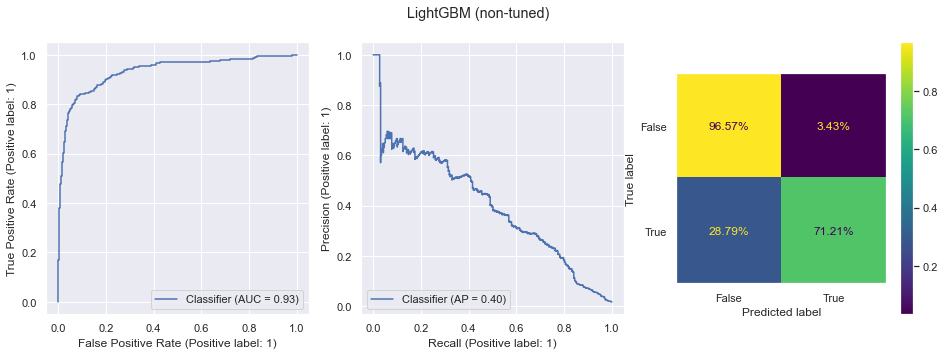

In [45]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

(X_train_lgbm, y_train_lgbm), (X_test_lgbm, y_test_lgbm) = \
    sci_train.encode_ccs_onehot().xy(outcome=Notebook.OUTCOME, fillna=True), \
    sci_test.encode_ccs_onehot().xy(outcome=Notebook.OUTCOME, fillna=True),

drop_exclusive_cols(X_train_lgbm, X_test_lgbm)

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        ("lightgbm", LGBMClassifier(metric=["l2", "auc"], is_unbalance=True)),
    ]
).fit(X_train_lgbm.copy(), y_train_lgbm)

Notebook.MODELS["LightGBM"] = model

Notebook.EVAL_RESULTS['LightGBM'] = evaluate(
    model,
    X_test_lgbm.copy(),
    y_test_lgbm,
    plot_title="LightGBM (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_lightgbm.png",
)


#### Thresholding
We adjust the classification threshold to further minimise false-negatives. Here we set it such that training recall/sensitivity is 0.85.

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.862818,0.095824,0.848249,0.932613,0.172196,0.330003


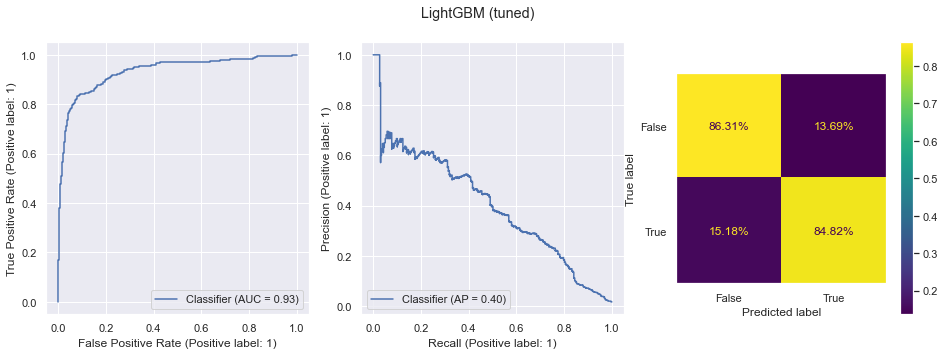

In [196]:
model = Notebook.MODELS["LightGBM"]

threshold = get_threshold(
    y_test_lgbm, 
    model.predict_proba(X_test_lgbm)[:, 1], 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS['LightGBM'] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_lightgbm.png",
)


### Explanations

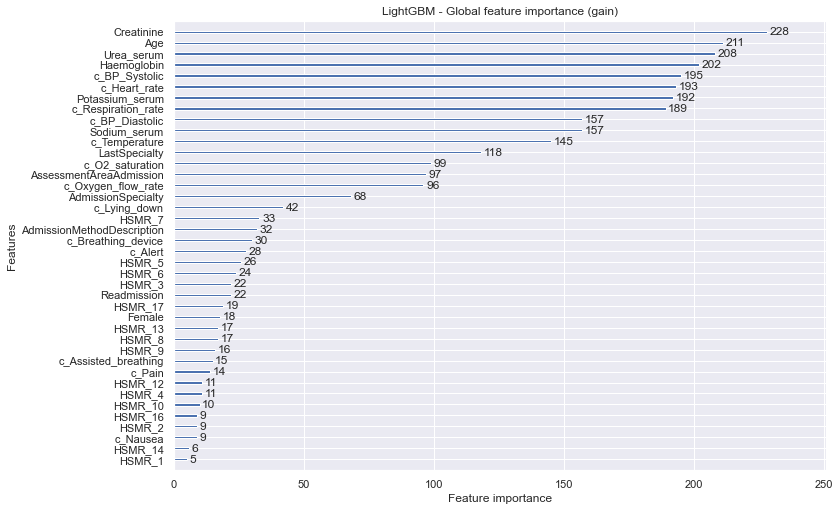

In [47]:
import lightgbm as lgb

fig = lgb.plot_importance(model["lightgbm"])
fig.set_title("LightGBM - Global feature importance (gain)")
plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_lightgbm.png", bbox_inches="tight")



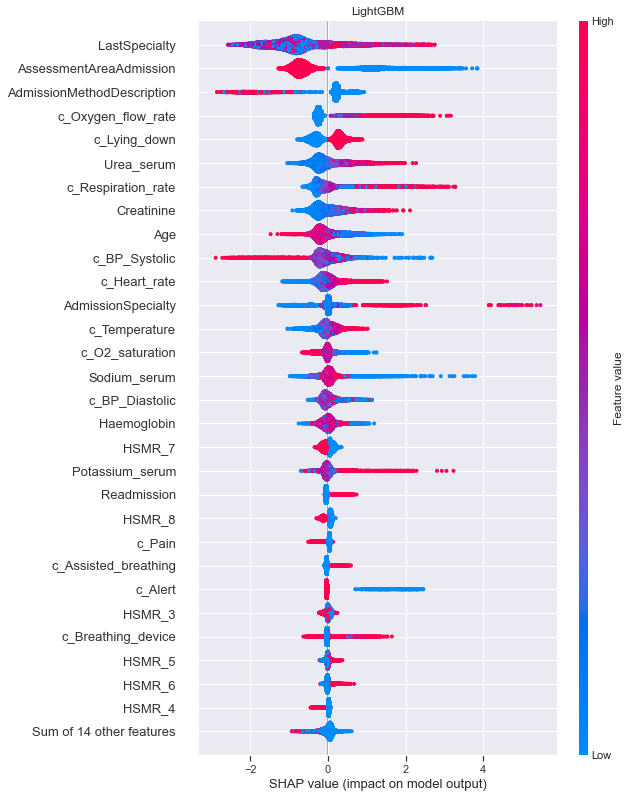

In [48]:
import shap

explainer = shap.TreeExplainer(model["lightgbm"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS["LightGBM"] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values[:, :, 1], max_display=30, show=False)
plt.title("LightGBM")
plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight")


In [49]:
sns.set_style('white')
positive_class_idx = np.where(model.predict(X_test_lgbm))[0][-1]
fig = shap.plots.force(shap_values[positive_class_idx, :, 1], matplotlib=True)

shap.save_html(f"{Notebook.IMAGE_DIR}/force_plot_lightgbm.html", fig)
display(fig)
sns.set_style('darkgrid')


## TabNet

Deep-learning model.

In [50]:
categorical_cols_idx, categorical_cols_dims = X_train.describe_categories()

(X_train_tn, X_valid_tn, y_train_tn, y_valid_tn) = train_test_split(
    X_train.to_numpy(),
    y_train.to_numpy(),
    stratify=y_train,
    test_size=0.33,
    random_state=42,
)


In [51]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = dict(
    n_a=24,
    n_d=24,
    cat_idxs=categorical_cols_idx,
    cat_dims=categorical_cols_dims,
    cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.1),
    scheduler_params=dict(step_size=50, gamma=0.7),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",
    verbose=0,
)

model = TabNetClassifier(**tabnet_params)

model.fit(
    X_train=X_train_tn,
    y_train=y_train_tn,
    eval_set=[(X_train_tn, y_train_tn), (X_valid_tn, y_valid_tn),],
    eval_name=["train", "valid"],
    eval_metric=[F2TabNet],
    max_epochs=300,
    patience=50,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

Notebook.MODELS["TabNet"] = model



Early stopping occurred at epoch 68 with best_epoch = 18 and best_valid_F2 = 0.47919
Best weights from best epoch are automatically used!


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.959225,0.192953,0.447471,0.830914,0.269637,0.354064


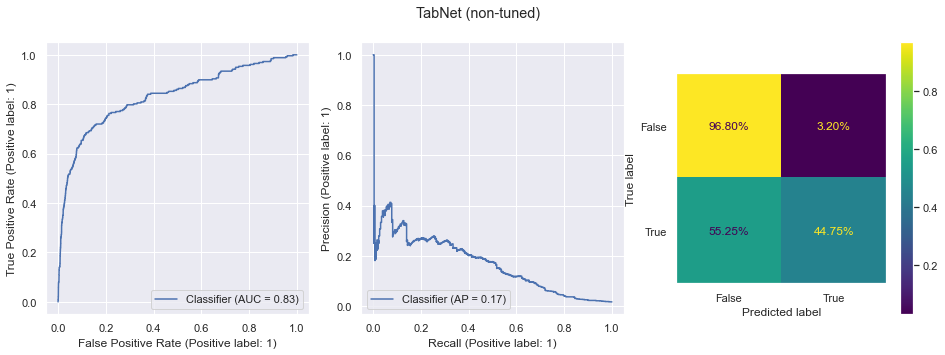

In [199]:
Notebook.EVAL_RESULTS['TabNet'] = evaluate(
    model, X_test.to_numpy(), y_test, "TabNet (non-tuned)", save=f"{Notebook.IMAGE_DIR}/eval_tabnet.png"
)



#### Thresholding

We adjust the classification threshold to further minimise false-negatives. Here we set it such that training recall/sensitivity is 0.785.

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.716146,0.045049,0.785992,0.830914,0.085214,0.183237


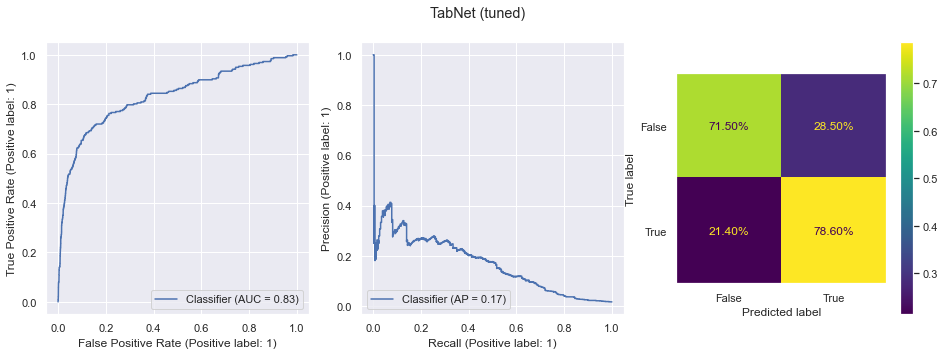

In [200]:
model = Notebook.MODELS["TabNet"]

threshold = get_threshold(
    y_test, 
    model.predict_proba(X_test.to_numpy())[:, 1],
    target=0.785
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS['TabNet'] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_tabnet.png",
)


### Explanations

#### SHAP

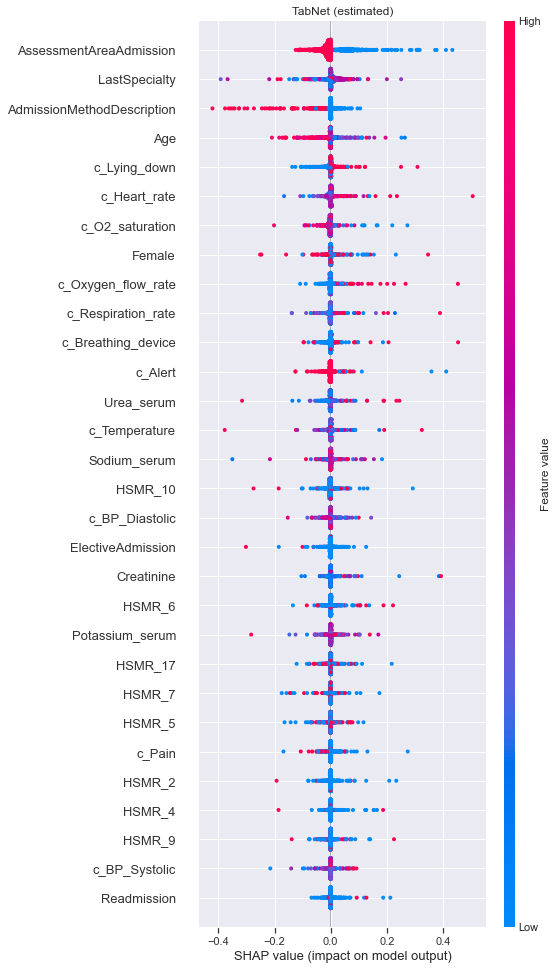

In [158]:
X_test_tn_shap = shap.sample(X_test.to_numpy(), 1000)
explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train_tn, 100))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_test_tn_shap, nsamples=50)

Notebook.EXPLAINERS["TabNet"] = (explainer, shap_values)

shap.summary_plot(shap_values[1], X_test_tn_shap, feature_names=X_test.columns, show=False, max_display=30)
plt.title("TabNet (estimated)")
plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_tabnet.png", bbox_inches="tight")

In [153]:
sns.set_style('white')
positive_class_idx = np.where(model.predict(X_test_tn_shap))[0][-1]
fig = shap.plots.force(
    explainer.expected_value[1],
    shap_values[1][positive_class_idx],
    X_test_tn_shap[positive_class_idx],
    feature_names=X_test.columns,
    matplotlib=True
)

shap.save_html(f"{Notebook.IMAGE_DIR}/force_plot_tabnet.html", fig)
display(fig)
sns.set_style('darkgrid')


#### Built-in Explanations

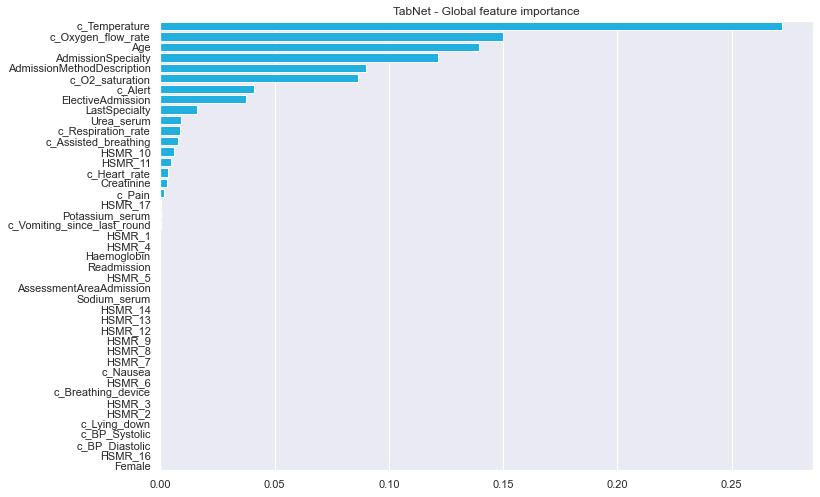

In [54]:
sorted_idx = model.feature_importances_.argsort()[::-1]
fig = sns.barplot(
    x=model.feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
)
fig.set_title("TabNet - Global feature importance")
plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_tabnet.png", bbox_inches="tight")



<AxesSubplot:>

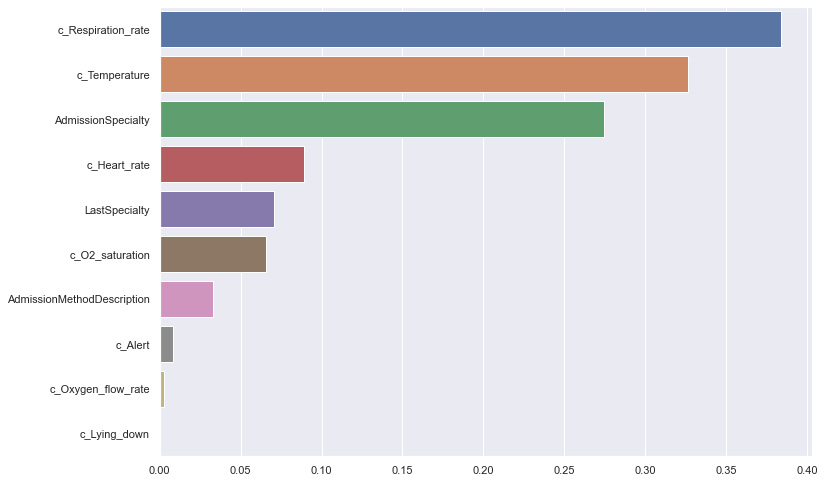

In [167]:
positive_class_idx = np.where(model.predict(X_test.to_numpy()))[0][-1]
explain_matrix, masks = model.explain(
    X_test.to_numpy()[positive_class_idx : positive_class_idx + 1]
)
explain_matrix = explain_matrix[0]
sorted_idx = explain_matrix.argsort()[::-1][:10]
sns.barplot(x=explain_matrix[sorted_idx], y=X_test.columns[sorted_idx])


## Comparisons

### Pre-tuning Scores

In [209]:
pd.concat([
    results[0].assign(Model=key) for key, results in Notebook.EVAL_RESULTS.items()
]).set_index('Model')

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,,,,,,
Logistic Regression,0.852412,0.083403,0.778210,0.890191,0.150659,0.291886
XGBoost,0.965050,0.253119,0.552529,0.925394,0.347188,0.446822
Random Forest,0.980692,0.407767,0.326848,0.909422,0.362851,0.340357
Isolation Forest,0.922704,0.092593,0.408560,0.838115,0.150971,0.242831
LightGBM,0.961385,0.261803,0.712062,0.932613,0.382845,0.529820
TabNet,0.959225,0.192953,0.447471,0.830914,0.269637,0.354064


### Tuned Scores

In [210]:
pd.concat([
    results[0].assign(Model=key) for key, results in Notebook.TUNED_RESULTS.items()
]).set_index('Model')

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,,,,,,
Logistic Regression,0.835788,0.076373,0.789883,0.890191,0.139280,0.275366
XGBoost,0.706656,0.050628,0.926070,0.925394,0.096006,0.207715
Random Forest,0.963807,0.250842,0.579767,0.909422,0.350176,0.459309
Isolation Forest,0.701682,0.044675,0.821012,0.838115,0.084739,0.183446
LightGBM,0.862818,0.095824,0.848249,0.932613,0.172196,0.330003
TabNet,0.716146,0.045049,0.785992,0.830914,0.085214,0.183237


### Plots

In [37]:
def joint_plot(subplots, filename=None, ax=None, title=None, style='white', legend_location='lower right', baseline_key='Baseline (NEWS)', plot_baseline=True):
    sns.set_style(style)
    plt.rc('axes', titlesize=16)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    for key, plot in subplots.items():
        if key != baseline_key:
            plot.plot(ax=ax, name=key)
        
    ax.set_title(title)
    ax.legend(loc=legend_location)

    if filename:
        plt.savefig(f'{Notebook.IMAGE_DIR}/{filename}_no_baseline.png', bbox_inches='tight')

    if baseline_key in subplots.keys() and plot_baseline:
        subplots[baseline_key].plot(ax=ax, linestyle='--', color='dimgray', name=baseline_key)
    ax.legend(loc=legend_location)

    if filename:
        plt.savefig(f'{Notebook.IMAGE_DIR}/{filename}.png', bbox_inches='tight')

    plt.rc('axes', titlesize=12) # Revert to default

In [31]:
roc_dict, pr_dict = {
    key: val[1] for key, val in Notebook.EVAL_RESULTS.items()
}, {
    key: val[2] for key, val in Notebook.EVAL_RESULTS.items()
}, 

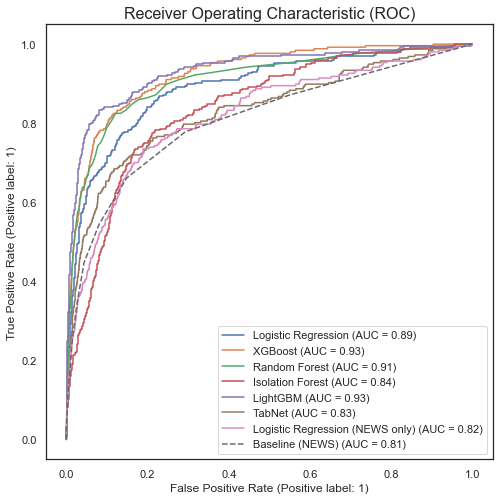

In [38]:
joint_plot(
    roc_dict, filename='combined_roc_curve', ax=None, title='Receiver Operating Characteristic (ROC)'
)

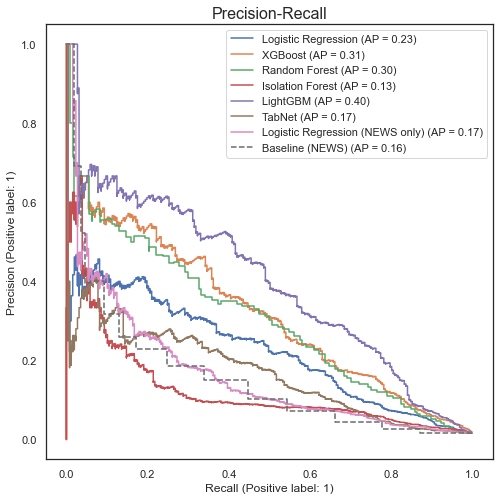

In [39]:
joint_plot(
    pr_dict, filename='combined_pr_curve', ax=None, title='Precision-Recall', legend_location='upper right'
)

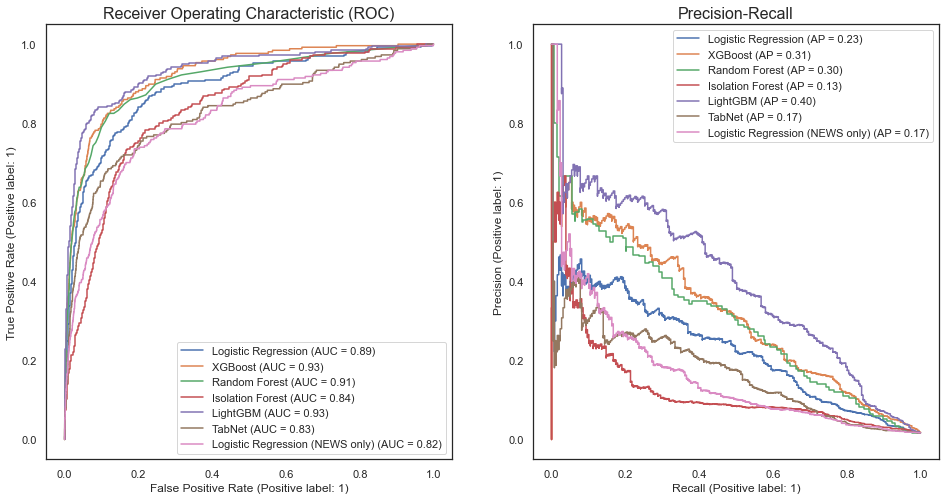

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title='Precision-Recall', legend_location='upper right', plot_baseline=False
)
joint_plot(
    roc_dict, ax=ax[0], title='Receiver Operating Characteristic (ROC)', plot_baseline=False
)

plt.savefig(f"{Notebook.IMAGE_DIR}/combined_curves_no_baseline.png", bbox_inches="tight")

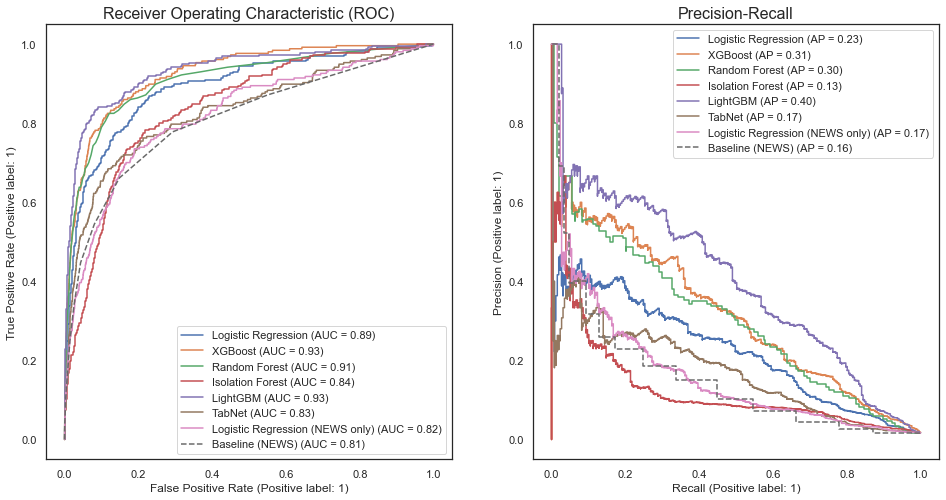

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title='Precision-Recall', legend_location='upper right',
)
joint_plot(
    roc_dict, ax=ax[0], title='Receiver Operating Characteristic (ROC)', 
)

plt.savefig(f"{Notebook.IMAGE_DIR}/combined_curves.png", bbox_inches="tight")

### Explanations

In [56]:
y_preds = pd.DataFrame(
    {
        key: model.predict(
            {
                "LightGBM": X_test_lgbm,
                "Isolation Forest": X_test_if,
                "TabNet": X_test.to_numpy(),
                "XGBoost": X_test,
                "Random Forest": X_test,
                "Logistic Regression": X_test,
                "Logistic Regression (NEWS only)": X_test
            }[key]
        )
        for key, model in Notebook.MODELS.items()
    }
)
del y_preds["Logistic Regression (NEWS only)"]

candidates = y_preds[y_preds.all(axis=1)].index

patient = candidates[0]
patient_data = X_test_lgbm.iloc[patient].apply(
    lambda x: f"{x:.2f}" if type(x) == np.float64 else x
)
patient_data_if = X_test_if.iloc[patient].copy()
patient_data_if.update(X_test_lgbm.iloc[patient])


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but IsolationForestWrapper was fitted without feature names


In [397]:
explanations = {
    modelkey: shap_values[patient]
    for modelkey, (_, shap_values) in Notebook.EXPLAINERS.items()
    if modelkey != "TabNet"
}
for _ in ["LightGBM", "Random Forest"]:
    explanations[_] = explanations[_][:, 1]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    tabnet_explainer = Notebook.EXPLAINERS["TabNet"][0]
    explanations["TabNet"] = shap.Explanation(
        tabnet_explainer.shap_values(X_test.to_numpy()[patient])[1],
        data=patient_data.values,
        base_values=tabnet_explainer.expected_value[1],
        feature_names=patient_data.index,
    )


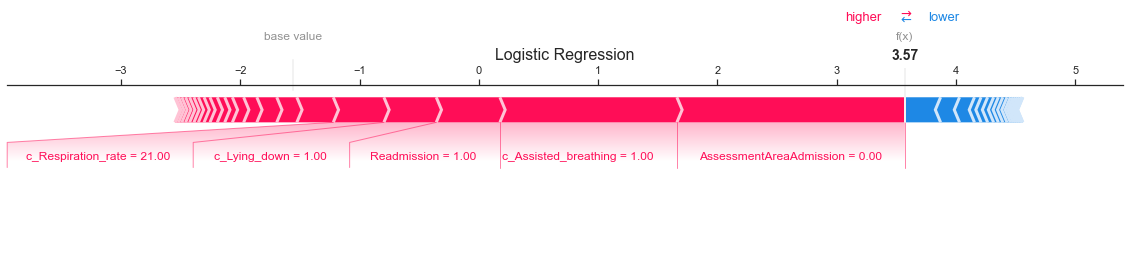

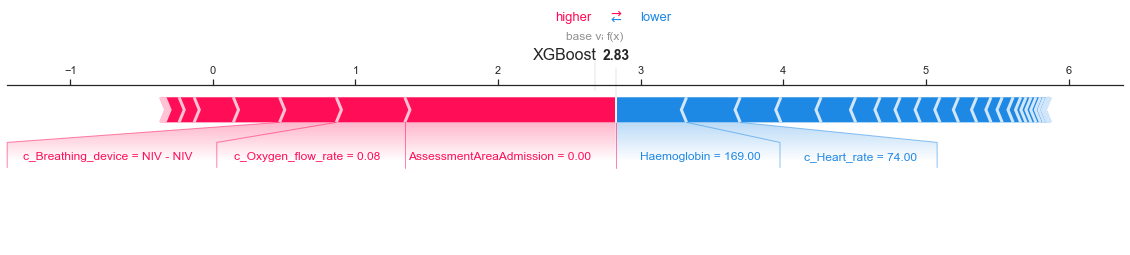

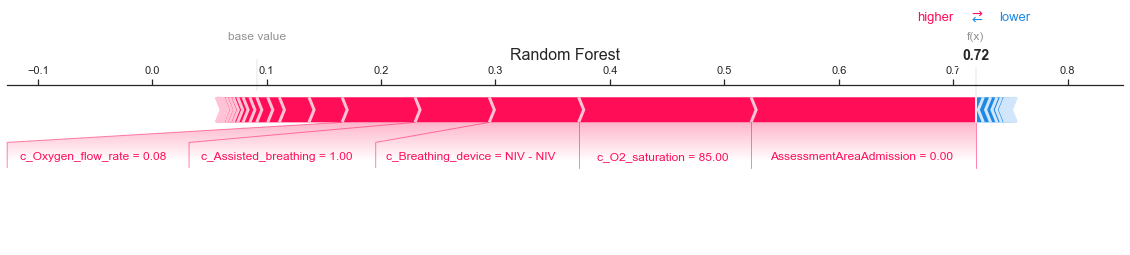

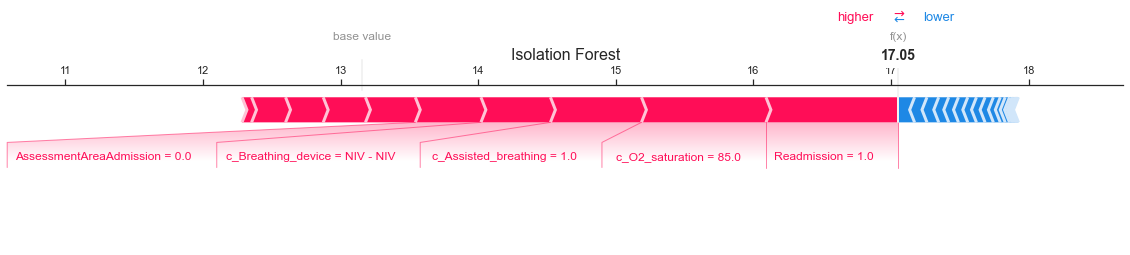

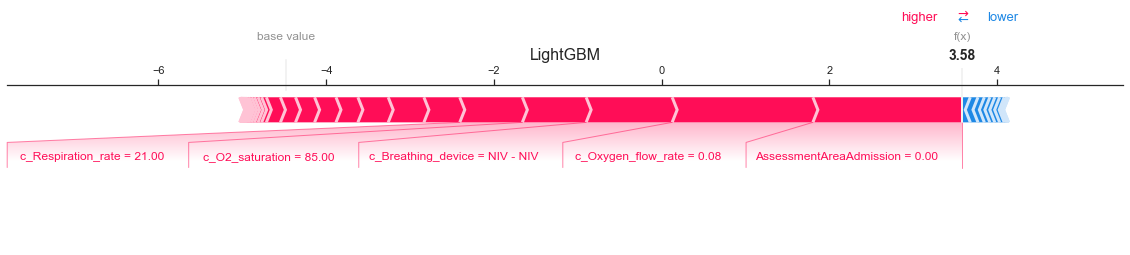

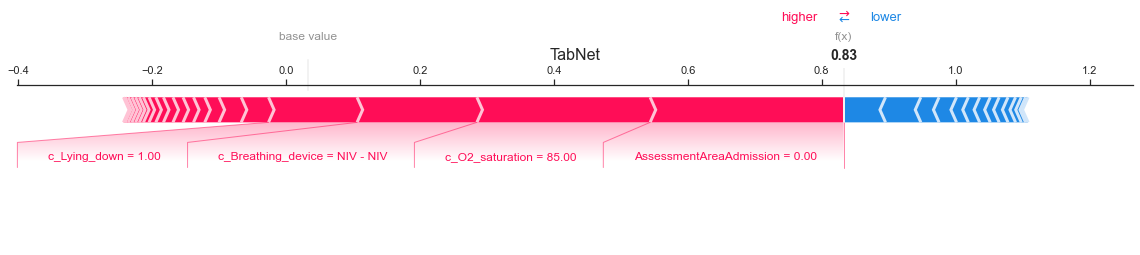

In [398]:
sns.set_style('white')
for modelkey, explanation in explanations.items():
    patient_to_use = patient_data if modelkey != "Isolation Forest" else patient_data_if

    explanation = shap.Explanation(explanation)
    explanation.data = patient_to_use.values

    fig = shap.plots.force(
        explanation,
        feature_names=patient_to_use.index,
        matplotlib=True,
        contribution_threshold=0.08,
        show=False,
    )

    plt.title(modelkey)
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
        bbox_inches="tight",
    )


In [261]:
if Notebook.SAVE_MODELS:
    with open(f'{Notebook.MODEL_DIR}/models.bin', 'wb') as file:
        pickle.dump(Notebook.MODELS, file)

    with open(f'{Notebook.MODEL_DIR}/explainers.bin', 'wb') as file:
        pickle.dump(Notebook.EXPLAINERS, file)

    with open(f'{Notebook.MODEL_DIR}/eval_results.bin', 'wb') as file:
        pickle.dump(Notebook.EVAL_RESULTS, file)

    with open(f'{Notebook.MODEL_DIR}/tuned_results.bin', 'wb') as file:
        pickle.dump(Notebook.TUNED_RESULTS, file)